In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

2025-09-25 04:32:51.109403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758774771.351538      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758774771.422029      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/butterfly-image-classification' 
train_csv_path = os.path.join(dataset_path, 'Training_set.csv')
test_csv_path = os.path.join(dataset_path, 'Testing_set.csv')
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [3]:
# Step 3: Load the training CSV and explore the data
train_df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
print("Training set shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())
print("\nUnique classes:", train_df['label'].nunique())
print("Class distribution:")
print(train_df['label'].value_counts().head())

Training set shape: (6499, 2)

First few rows:
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

Unique classes: 75
Class distribution:
label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
Name: count, dtype: int64


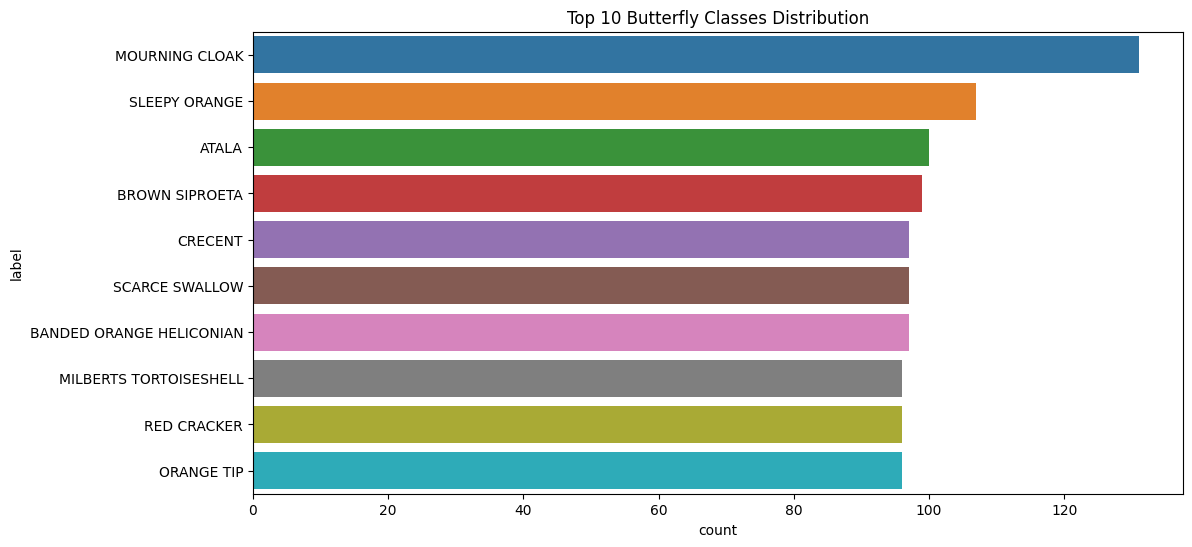

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index[:10])
plt.title('Top 10 Butterfly Classes Distribution')
plt.show()

In [5]:
# Step 4: Encode labels
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 75


In [6]:
# Step 5: Define image loading and preprocessing function
IMG_SIZE = (224, 224)  # Standard size for many CNNs; adjust if needed for memory
def load_and_preprocess_image(image_path, label):
    """
    Load image, resize, normalize, and return as numpy array.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None
        image = cv2.resize(image, IMG_SIZE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = image.astype('float32') / 255.0  # Normalize to [0,1]
        return image, label
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

In [7]:
# Step 6: Load training images with preprocessing
# This may take time (~1000+ images); run on GPU for speed
print("Loading and preprocessing training images...")
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image_filename = row['filename']
    image_path = os.path.join(train_dir, image_filename)
    result = load_and_preprocess_image(image_path, row['label_encoded'])
    if result is not None:
        img, lbl = result
        train_images.append(img)
        train_labels.append(lbl)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Loaded {len(train_images)} training images with shape {train_images.shape}")

Loading and preprocessing training images...
Loaded 6499 training images with shape (6499, 224, 224, 3)


In [8]:
# Step 7: One-hot encode labels
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)

Training set: 5199 images
Validation set: 1300 images


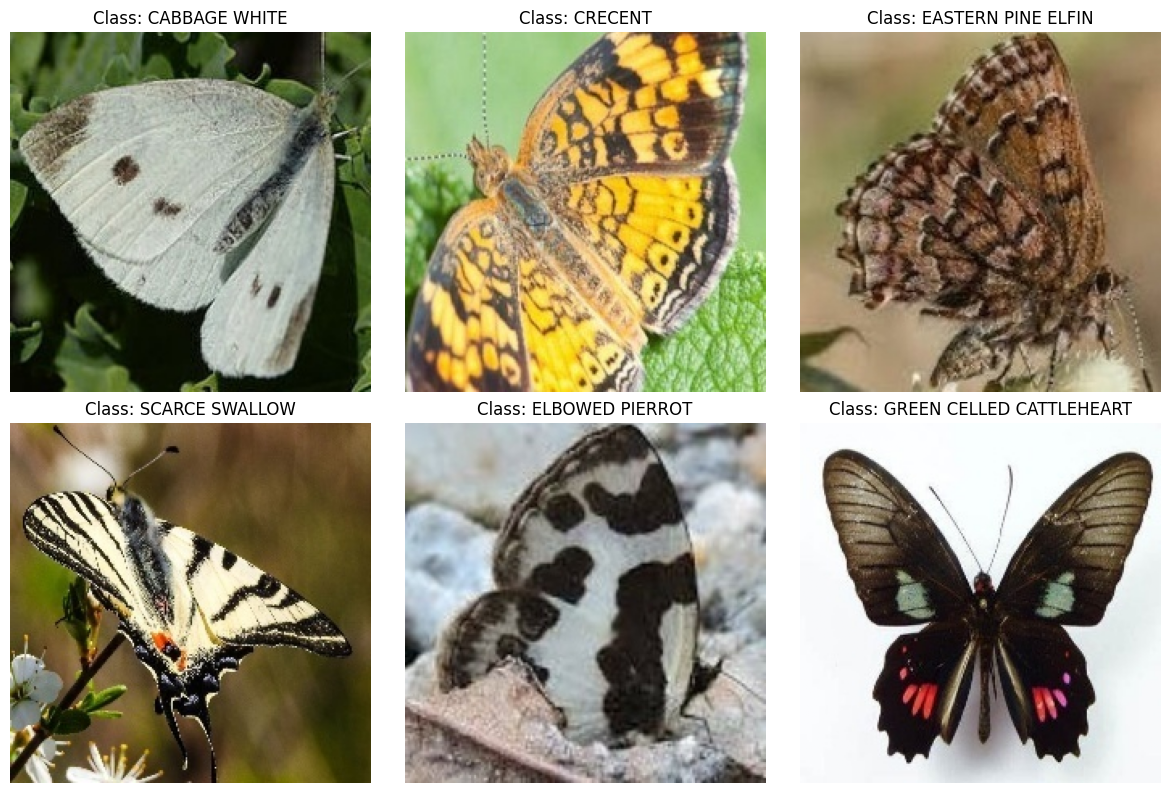

In [9]:
# Step 8: Split into train and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels_cat, test_size=0.2, random_state=42, stratify=train_labels
)
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")

# Visualize a few sample images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[idx])
    true_label = np.argmax(y_train[idx])
    plt.title(f"Class: {label_encoder.inverse_transform([true_label])[0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Step 9: Data Augmentation (to prevent overfitting)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [11]:
# Step 10: Build the CNN Model
model = Sequential([
    # First Conv Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Third Conv Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Fourth Conv Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-09-25 04:34:04.280556: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,720,459 (37.08 MB)

 Trainable params: 9,718,731 (37.07 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.0648 - loss: 4.5401 - val_accuracy: 0.0223 - val_loss: 10.9977
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.1562 - loss: 3.7123 - val_accuracy: 0.0215 - val_loss: 11.2078
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.1616 - loss: 3.5637 - val_accuracy: 0.0354 - val_loss: 7.4092
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.1562 - loss: 3.1619 - val_accuracy: 0.0369 - val_loss: 7.3809
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.2475 - loss: 3.0345 - val_accuracy: 0.1115 - val_loss: 4.6108
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.2188 - loss: 2.8688 - val_accuracy: 0.1138 - val_loss: 4.5968
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.2854 - loss: 2.7439 - val_accuracy: 0.2762 - val_loss: 2.6811
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.3125 - loss: 2.6405 

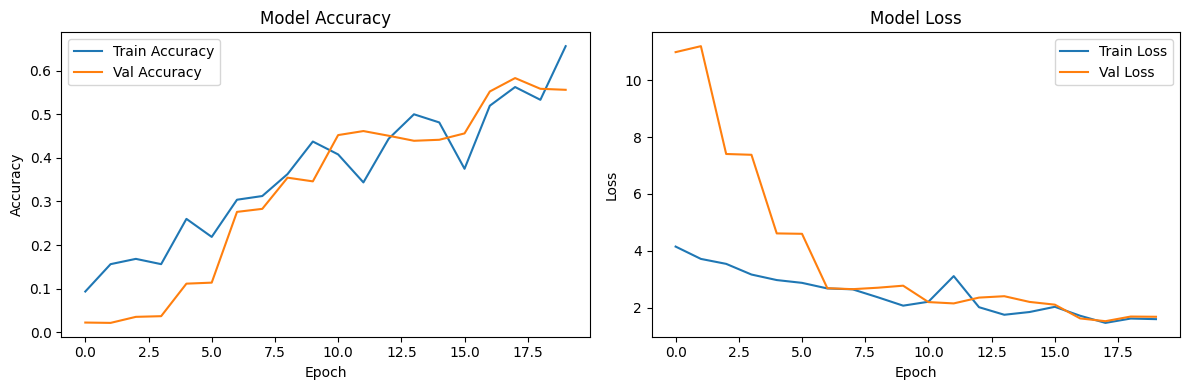

In [12]:
# Step 11: Train the model
# Use GPU/TPU in Kaggle for faster training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=20,  # Adjust based on time; start with 10-20
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
#Step 12: Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 528ms/step - accuracy: 0.5626 - loss: 1.5946
Validation Accuracy: 0.5562


In [14]:
# Step 13: Predict on test set
test_df = pd.read_csv(test_csv_path)
print("Test set shape:", test_df.shape)

test_images = []
test_filenames = test_df['filename'].values  # Assuming column name is 'filename'

print("Loading and preprocessing test images...")
for filename in test_filenames:
    image_path = os.path.join(test_dir, filename)
    result = load_and_preprocess_image(image_path, None)  # No label for test
    if result is not None:
        img, _ = result
        test_images.append(img)

test_images = np.array(test_images)
print(f"Loaded {len(test_images)} test images")

# Make predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

Test set shape: (2786, 1)
Loading and preprocessing test images...
Loaded 2786 test images
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 529ms/step


Submission file 'submission.csv' created! Download and submit it to the competition.


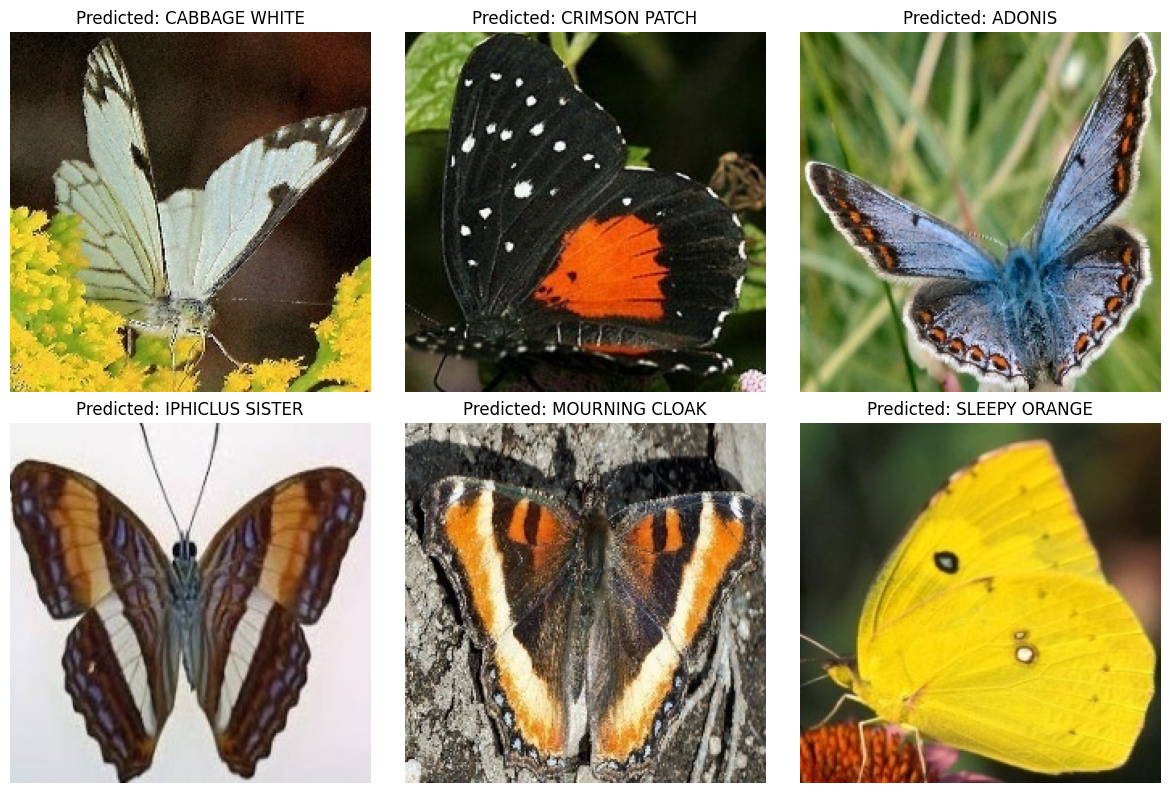

In [15]:
# Step 14: Create submission CSV
submission_df = pd.DataFrame({
    'filename': test_filenames,
    'label': predicted_labels
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created! Download and submit it to the competition.")

# Optional: Visualize some test predictions
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()